## Imports

In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import glob
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pyarrow 
import shap

## Read data and train-test-split

In [3]:
# Read in parquet files and drop NAs 
df_selected = pd.read_parquet('../data/events_with_hit_features_[cut_off_time=0.5].parquet').dropna()

# Filter for muons only for the training set
df_muons = df_selected.query('`class`== "muon"')

# Train test split (muon data)
train_df, test_df_muon = train_test_split(df_muons, random_state=42)

# Append pion data to the test set 
test_df = pd.concat([test_df_muon, df_selected.query('`class`== "pion"')])

# Define X and y
X_train = train_df.iloc[:, 1:19].reset_index(drop=True)
y_train = train_df['ring_radius_cal'].reset_index(drop=True)
X_test = test_df.iloc[:, 1:19].reset_index(drop=True)
y_test = test_df['ring_radius_cal'].reset_index(drop=True)



## Train the model

In [4]:
# Define the model
xgb_reg = xgb.XGBRegressor()

# Fit the model 
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Global SHAP analysis 

In [5]:
# Extract feature names
feature_names = X_train.columns

# Define the tree explainer
xgb_explainer = shap.TreeExplainer(xgb_reg)

# Explainer for training data
train_xgb_shap_values = xgb_explainer.shap_values(X_train)

# Explainer for test data
test_xgb_shap_values = xgb_explainer.shap_values(X_test)

# Display global shap values for each feature in descending order 
values = np.abs(train_xgb_shap_values).mean(0) 
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,SHAP
hit_distance_median,5.456018
hit_distance_q25,0.781787
hit_distance_q75,0.536898
y_aligned_max,0.479577
hull_diameter,0.263208
x_aligned_max,0.191510
hit_distance_mean,0.149050
hull_area,0.144011
x_aligned_min,0.133275
total_in_time_hits,0.129795


## SHAP summary plot on train set

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


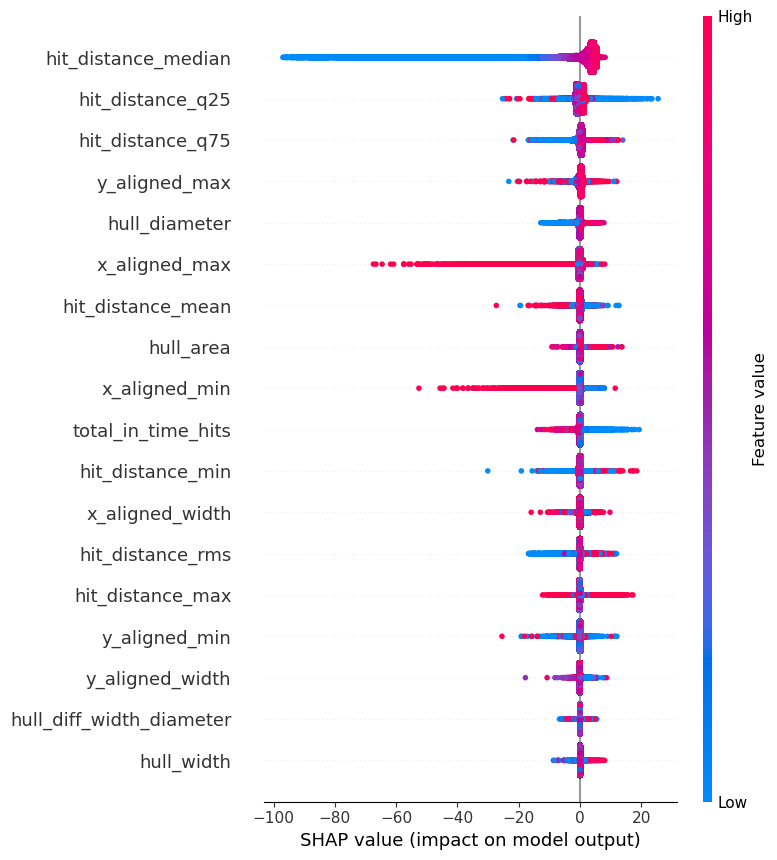

In [6]:
# Show shap summary plot on train set
shap.summary_plot(train_xgb_shap_values, X_train)

## SHAP summary plot on test set

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


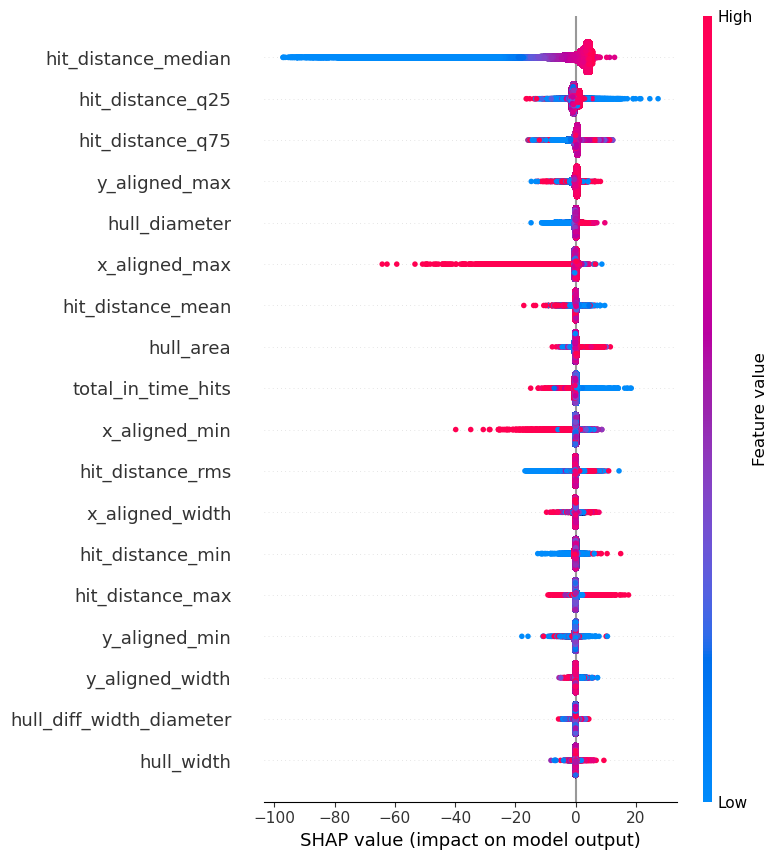

In [7]:
# Show shap summary plot on test set
shap.summary_plot(test_xgb_shap_values, X_test)

## SHAP dependence plot 
##### showing SHAP value of `hit_distance_median` vs. `hit_distance_median` feature value

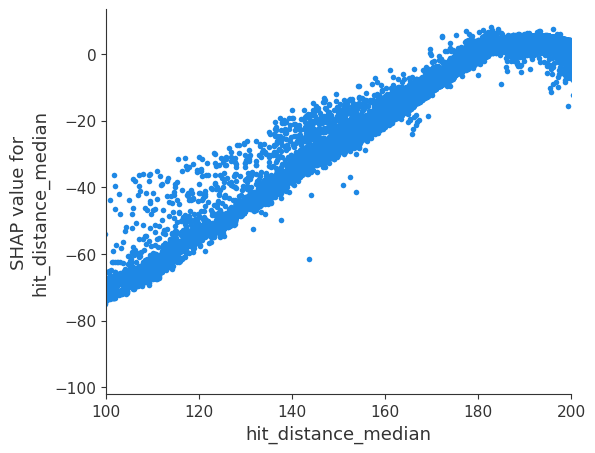

In [8]:
# Dependence plot of shap value of `hit_distance_median` vs. `hit_distance_median` feature value 
shap.dependence_plot("hit_distance_median", train_xgb_shap_values, X_train, interaction_index=None, xmin=100, xmax=200)